# Exploratory data Analysis

## Library

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency
# import ace_tools_open as tools
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [19]:
file_path = 'Laminitis.xlsx'
# Step 1: Reload the data, treating the first two rows as headers
df_raw = pd.read_excel(file_path)

# Step 2: Flatten the multi-level column headers
df_raw.columns = [' '.join([str(i) for i in col if str(i) != 'nan']).strip() for col in df_raw.columns]

# Step 3: Display the cleaned header and first few rows
df_cleaned = df_raw.copy()
# Assuming your DataFrame is called df
df_cleaned.columns = df_cleaned.columns.str.strip()  # Remove leading/trailing spaces
df_cleaned.columns = df_cleaned.columns.str.replace(' ', '')  # Replace spaces with underscores

# Drop last 3 rows/Drop rows with more than 90% missing values
# df_cleaned.drop([21,27,28,30],inplace=True)
df_cleaned = df_cleaned[df_cleaned.isnull().mean(axis=1) < 0.9]

#df_cleaned = df_cleaned.iloc[22,28,29,31,48,49,50]
df_cleaned.shape

(47, 41)

## Drop the columns which is not contributing much

In [20]:
df_cleaned.drop(columns=['Horse#', 'HVMS#', 'Dateofstudy(mm/dd/yy)', 'Dateofbirth(mm/dd/yy)',
                         'Girth(cm)', 'Flank(cm)', 'Photo4feet', 'Xray4feet', 'Bloodcollection',
                         'IncludedinStudy', 'additionalcomments','LLRF','LLLF','LLRH','LLLH','Sedation(xylazine-mL)'], inplace=True)

## Converting the sign value into numerical values

### Check for the unique values in the columns so we can convert it into numerical values

In [21]:
# # Step 1: Extract relevant columns to inspect their unique values
# columns_to_check = [
#     'Sex',
#     'LLRF',
#     'LLLF',
#     'LLRH',
#     'LLLH'
# ]

# # Get unique values from ea?ch column to understand how to convert them to numeric
# unique_values = {col: df_cleaned[col].unique() for col in columns_to_check}
# unique_values

### Convert categorical values into numerical values

In [22]:
df_cleaned['Sex'] = df_cleaned['Sex'].map({
    'Female': 0,
    # 'Stallion': 1,
    'Gelding': 1
})

In [23]:
df_cleaned.head()

,Age(years),Sex,HeartRate,Respiratoryrate,Rectaltemperature,Gutsounds,Column1,Bodyweight(kg),BodyConditionScoring(outof9),LengthRF,...,WidthRH,WidthLH,HTRF,HTLF,HTRH,HTLH,LERF,LELF,LERH,LELH
0,3,0.0,40.0,16.0,37.3,WNL,WNL,430.0,8.0,13.0,...,9.5,10.0,-,-,-,-,3.0,0.0,0.0,0.0
1,18,0.0,40.0,16.0,36.5,WNL,WNL,480.0,5.0,13.5,...,11.0,10.5,+,+,+,+,0.0,0.0,0.0,0.0
2,8,0.0,32.0,12.0,37.6,WNL,WNL,477.0,7.0,13.0,...,10.5,11.0,packing,packing,-,-,0.0,0.0,0.0,0.0
3,13,0.0,40.0,16.0,37.6,WNL,WNL,500.0,6.0,14.5,...,10.0,10.0,+,++,+,-,0.0,3.0,0.0,3.0
4,13,0.0,40.0,32.0,37.6,WNL,WNL,400.0,6.0,13.5,...,10.0,10.0,-,+,+,+,0.0,0.0,0.0,0.0


'+' (Plus): Indicates the presence of lameness in that specific leg.

'-' (Minus): Indicates the absence of lameness in that specific leg.

**'+' = 1, '++' = 1, '-' = 0, 'packing' = 0, 'toe+' = 1**

In [24]:
# Encode LL columns
# ll_cols = [
#     'LLRF',
#     'LLLF',
#     'LLRH',
#     'LLLH'
# ]
# for col in ll_cols:
#     df_cleaned[col] = df_cleaned[col].map({'+': 1, '-': 0})
#     df_cleaned[col] = df_cleaned[col].fillna(0)

# Encode Hoof Testers (HT) columns
ht_cols = [
    'HTRF',
    'HTLF',
    'HTRH',
    'HTLH'
]
for col in ht_cols:
    df_cleaned[col] = df_cleaned[col].map({'+': 1, '-': 0, '++': 1, 'toe+':1,'packing':0})
    df_cleaned[col] = df_cleaned[col].fillna(0)

Gut_cols = [
    'Gutsounds'
]
for col in Gut_cols:
    df_cleaned[col] = df_cleaned[col].map({'WNL': 1, 'decrease': 0})
    df_cleaned[col] = df_cleaned[col].fillna(0)

# Compute lameness score and risk level
df_cleaned['lameness_score'] = df_cleaned[[col for col in ht_cols]].sum(axis=1)
#print(df_cleaned['lameness_score'] )
# Map score to risk level: Low if score is 0, High if score is 1 or more
def map_score_to_risk(score):
    if score < 3 :
        return 'Low'
    else:
        return 'High'

df_cleaned['lameness_risk_level'] = df_cleaned['lameness_score'].apply(map_score_to_risk)

# Encode target labels (Low = 0, High = 1)
cat = pd.Categorical(df_cleaned['lameness_risk_level'].str.strip().str.title(),
                     categories=['Low', 'High'], ordered=True)
df_cleaned['lameness_risk_label'] = cat.codes   # Low=0, High=1, others=-1

# label_encoder = LabelEncoder()
# df_cleaned['lameness_risk_label'] = label_encoder.fit_transform(df_cleaned['lameness_risk_level'])

In [25]:
df_cleaned

,Age(years),Sex,HeartRate,Respiratoryrate,Rectaltemperature,Gutsounds,Column1,Bodyweight(kg),BodyConditionScoring(outof9),LengthRF,...,HTLF,HTRH,HTLH,LERF,LELF,LERH,LELH,lameness_score,lameness_risk_level,lameness_risk_label
0,3,0.0,40.0,16.0,37.3,1.0,WNL,430.0,8.0,13.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,Low,0
1,18,0.0,40.0,16.0,36.5,1.0,WNL,480.0,5.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,High,1
2,8,0.0,32.0,12.0,37.6,1.0,WNL,477.0,7.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,0
3,13,0.0,40.0,16.0,37.6,1.0,WNL,500.0,6.0,14.5,...,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,High,1
4,13,0.0,40.0,32.0,37.6,1.0,WNL,400.0,6.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,High,1
5,8,0.0,44.0,16.0,37.7,1.0,WNL,440.0,5.0,13.5,...,1.0,1.0,1.0,3.0,0.0,0.0,0.0,4.0,High,1
6,9,0.0,52.0,20.0,37.4,1.0,WNL,460.0,6.0,13.5,...,1.0,1.0,1.0,0.0,0.0,3.0,0.0,4.0,High,1
7,8,0.0,60.0,24.0,37.3,1.0,WNL,520.0,8.0,12.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Low,0
8,4,0.0,56.0,20.0,37.4,1.0,WNL,460.0,6.0,13.5,...,1.0,1.0,1.0,0.0,0.0,3.0,0.0,4.0,High,1
9,5,0.0,44.0,16.0,36.7,1.0,WNL,400.0,7.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,0


In [26]:
df_cleaned = df_cleaned.rename(columns={'Bodyweight(kg)':'Bodyweight','BodyConditionScoring(outof9)':'BodyConditionScoring','Column1':'Digitalpulses'})

In [27]:
## Converting digital pulses into numerical values
df_cleaned['Digitalpulses'].replace(['WNL', 'increased front feet', 'increased', 'increased hinds',
       'RF slightly increased', 'increased RF', 'increased fronts'], [0, 1, 2, 3, 4, 5, 6], inplace=True)

In [28]:
print(df_cleaned.shape)
df_cleaned.head()

(47, 28)


,Age(years),Sex,HeartRate,Respiratoryrate,Rectaltemperature,Gutsounds,Digitalpulses,Bodyweight,BodyConditionScoring,LengthRF,...,HTLF,HTRH,HTLH,LERF,LELF,LERH,LELH,lameness_score,lameness_risk_level,lameness_risk_label
0,3,0.0,40.0,16.0,37.3,1.0,0.0,430.0,8.0,13.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,Low,0
1,18,0.0,40.0,16.0,36.5,1.0,0.0,480.0,5.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,High,1
2,8,0.0,32.0,12.0,37.6,1.0,0.0,477.0,7.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,0
3,13,0.0,40.0,16.0,37.6,1.0,0.0,500.0,6.0,14.5,...,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,High,1
4,13,0.0,40.0,32.0,37.6,1.0,0.0,400.0,6.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,High,1


In [29]:
df_cleaned.columns

Index(['Age(years)', 'Sex', 'HeartRate', 'Respiratoryrate',
       'Rectaltemperature', 'Gutsounds', 'Digitalpulses', 'Bodyweight',
       'BodyConditionScoring', 'LengthRF', 'LengthLF', 'LengthRH', 'LengthLH',
       'WidthRF', 'WidthLF', 'WidthRH', 'WidthLH', 'HTRF', 'HTLF', 'HTRH',
       'HTLH', 'LERF', 'LELF', 'LERH', 'LELH', 'lameness_score',
       'lameness_risk_level', 'lameness_risk_label'],
      dtype='object')

# Feature Engineering

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [31]:
df = df_cleaned
df.head()

,Age(years),Sex,HeartRate,Respiratoryrate,Rectaltemperature,Gutsounds,Digitalpulses,Bodyweight,BodyConditionScoring,LengthRF,...,HTLF,HTRH,HTLH,LERF,LELF,LERH,LELH,lameness_score,lameness_risk_level,lameness_risk_label
0,3,0.0,40.0,16.0,37.3,1.0,0.0,430.0,8.0,13.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,Low,0
1,18,0.0,40.0,16.0,36.5,1.0,0.0,480.0,5.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,High,1
2,8,0.0,32.0,12.0,37.6,1.0,0.0,477.0,7.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,0
3,13,0.0,40.0,16.0,37.6,1.0,0.0,500.0,6.0,14.5,...,1.0,1.0,0.0,0.0,3.0,0.0,3.0,3.0,High,1
4,13,0.0,40.0,32.0,37.6,1.0,0.0,400.0,6.0,13.5,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,High,1


##  Looking for features which is correlated so we can remove

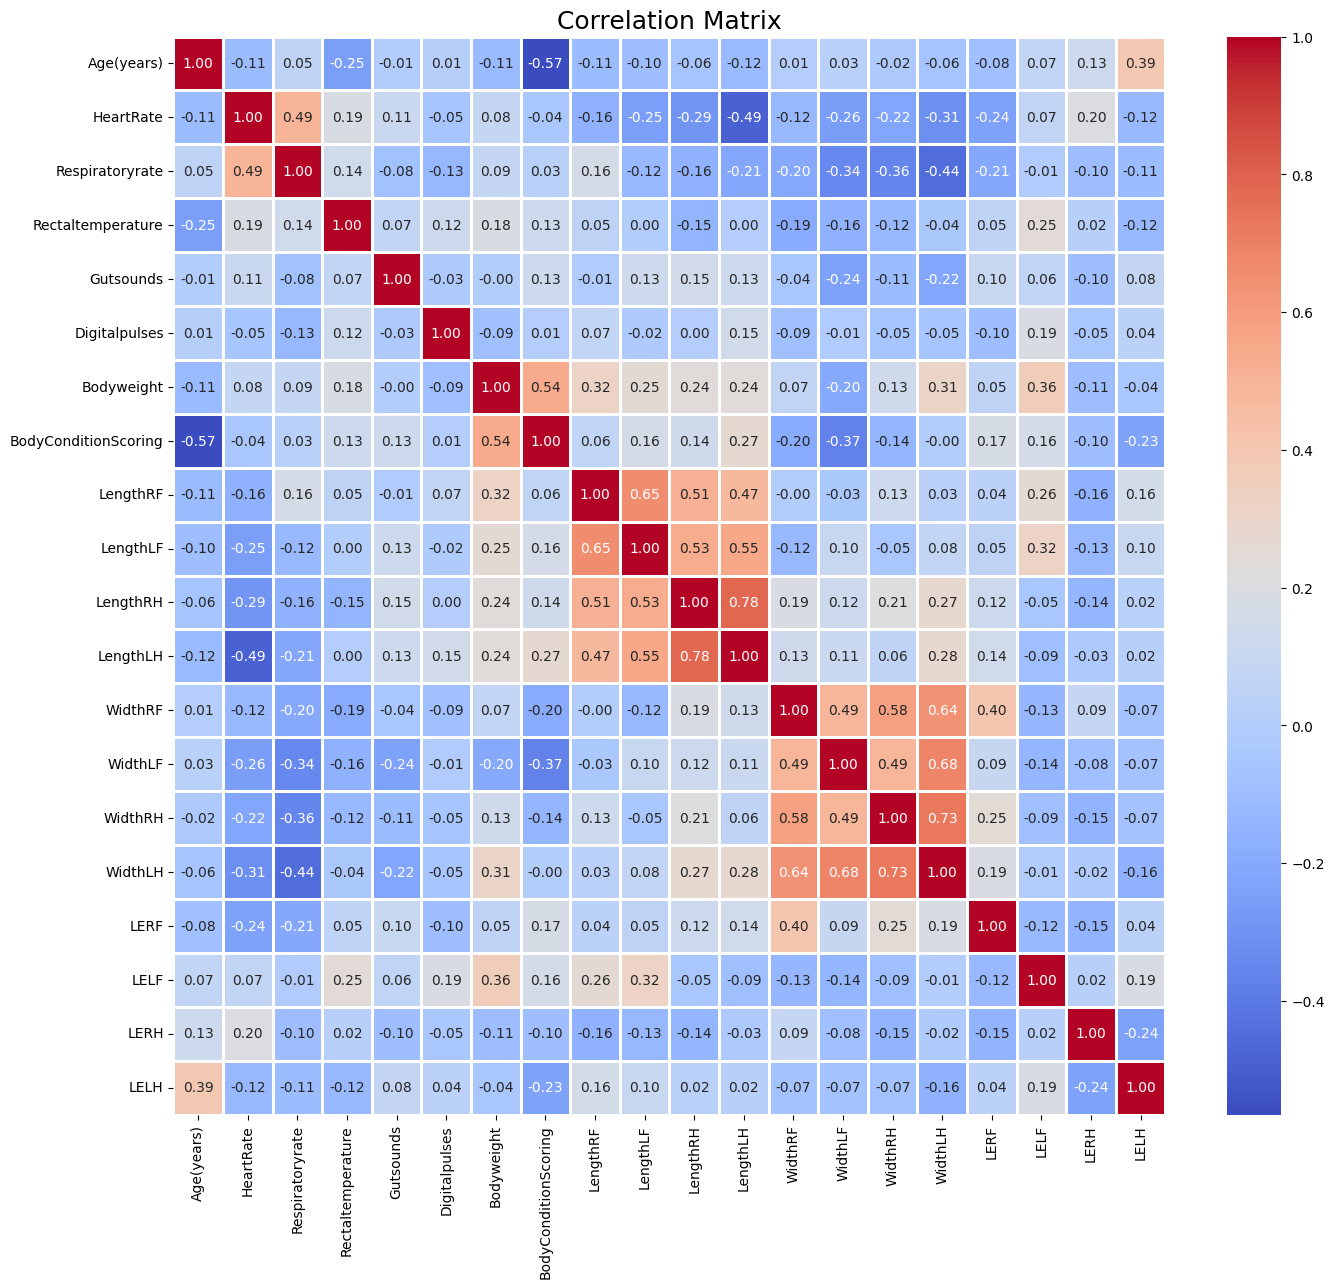

In [32]:
import os
featues = ['Age(years)','HeartRate', 'Respiratoryrate', 'Rectaltemperature', 'Gutsounds',
           'Digitalpulses', 'Bodyweight', 'BodyConditionScoring',
       'LengthRF', 'LengthLF', 'LengthRH', 'LengthLH', 'WidthRF', 'WidthLF',
       'WidthRH', 'WidthLH', 'LERF', 'LELF',
       'LERH', 'LELH']

# Visualize the distribution of heart rate
# sns.histplot(df['HeartRate'], kde=True)
# plt.title('Distribution of Heart Rate')
# plt.show()

# Assuming 'df' is your DataFrame and 'features' is the list of features you want to analyze
feat_corr = df[featues]

# Calculate the correlation matrix
correlation_matrix = feat_corr.corr()

# Create the heatmap with annotations (to show correlation values)
plt.figure(figsize=(16, 14))  # Adjust the figure size for better clarity
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.8, cmap='coolwarm', annot_kws={"size": 10})

# Add a title
plt.title('Correlation Matrix', fontsize=18)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Rotate y-axis labels for better visibility
plt.yticks(rotation=0)

#filepath = os.path.join('D:', 'Medical_Imaging', 'Risk Calculation', 'Laminitis', 'correlation_matrix_Lameness_score.png')
plt.savefig('correlation_matrix_Lameness_score.png',dpi=600, bbox_inches='tight')
plt.show()

### Fill the missing values with median

In [33]:
df = df[['Age(years)','HeartRate', 'Respiratoryrate', 'Rectaltemperature', 'Gutsounds',
          'Digitalpulses', 'Bodyweight', 'BodyConditionScoring',
         'LengthLH',
         'WidthRF', 'WidthLF',
         'LERF', 'LELF', 'LERH','LELH',
         'lameness_risk_label']]

# Impute missing numerical values with median
# num_cols = df.select_dtypes(include=[np.number]).columns
# df[num_cols] = df[num_cols].fillna(df[num_cols].median())
# df.shape
num_cols = df.select_dtypes(include='number').columns.drop('label', errors='ignore')
df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))
df.shape

(47, 16)

In [34]:
df.isna().value_counts().sum()

np.int64(47)

### Distribution Plot

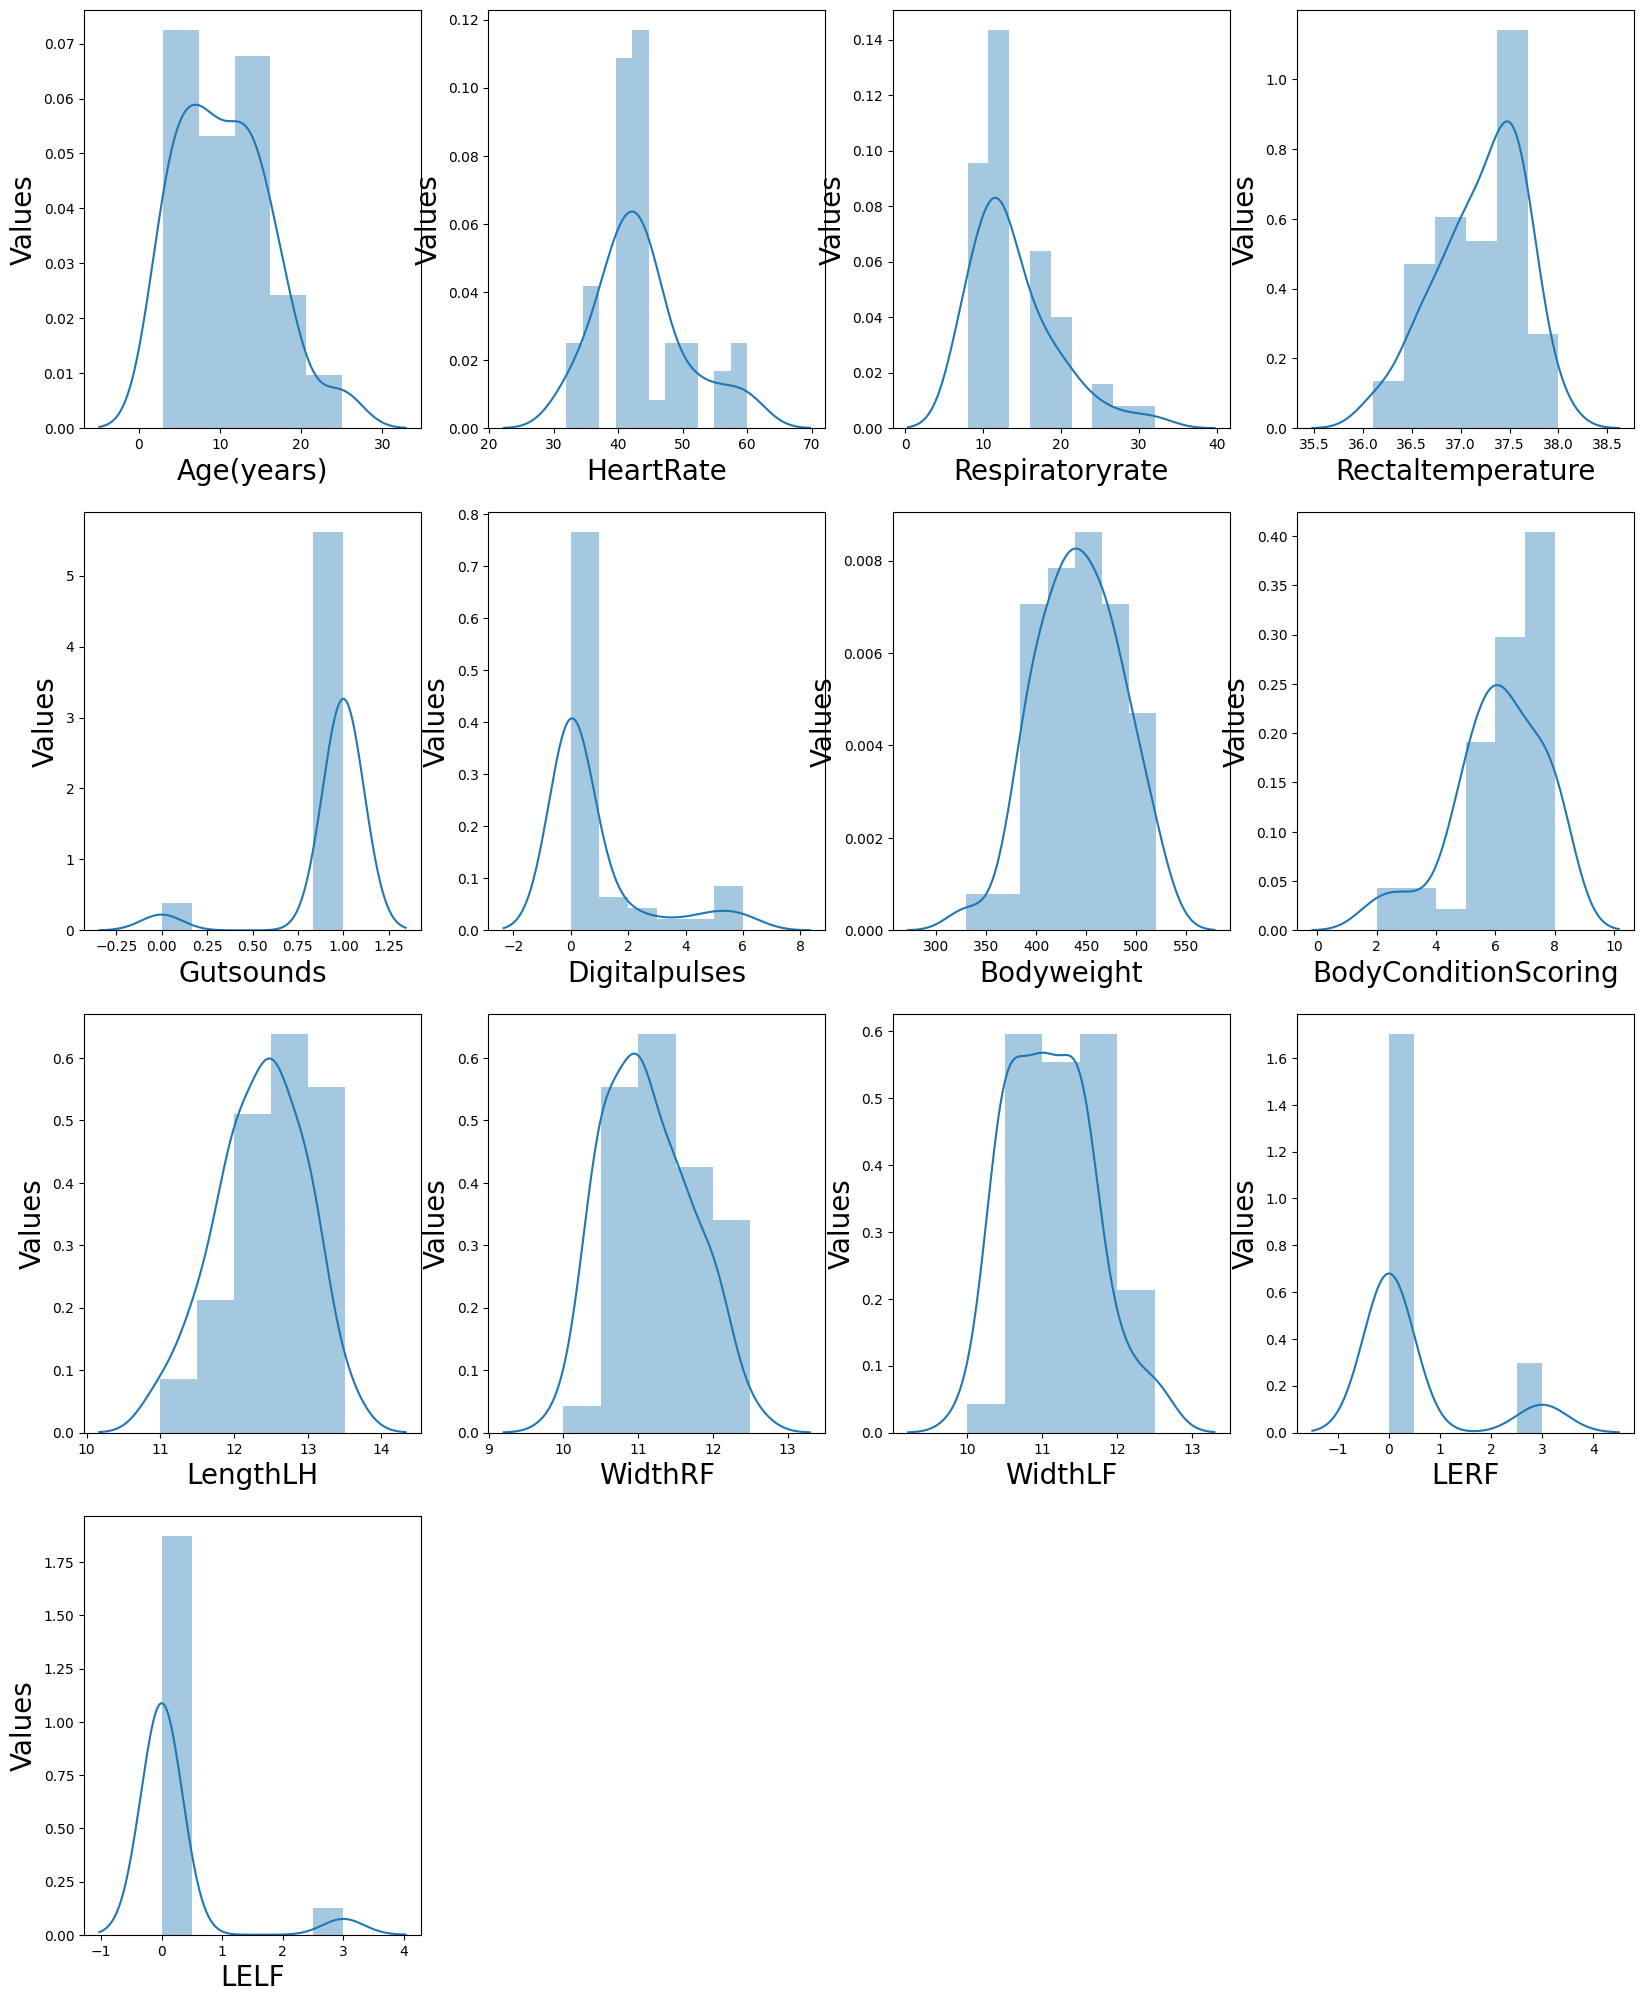

In [35]:
#Plotting the distribution plot.
plt.figure(figsize=(20,25))
plotnumber=1

for column in df:
    if plotnumber<14:
        ax=plt.subplot(4,4,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Values',fontsize=20)
    plotnumber+=1
plt.show()

# Logistic Regression for Risk score

In [36]:
features = ['Age(years)','HeartRate', 'Respiratoryrate', 'Rectaltemperature', 'Gutsounds',
  'Digitalpulses', 'Bodyweight', 'BodyConditionScoring',
 'LengthLH', 'WidthRF', 'WidthLF', 'LERF', 'LELF', 'LERH', 'LELH']

#  df = df[['Age(years)','HeartRate', 'Respiratoryrate', 'Rectaltemperature', 'Gutsounds',
#           'Digitalpulses', 'Bodyweight', 'BodyConditionScoring',
#          'LengthLH',
#          'WidthRF', 'WidthLF',
#          'LERF', 'LELF', 'LERH','LELH',
#          'lameness_risk_label']]

target = 'lameness_risk_label'
x = df[features]
y = df[target]
x.shape, y.shape
# # Adding constant term
# # Using Binomial distribution and logit function as link function which is default for Binomial family
# model_logistic = sm.GLM(y,(sm.add_constant(x)), family = sm.families.Binomial())
# res_logistic=model_logistic.fit()
# res_logistic.summary()

((47, 15), (47,))

In [37]:
# params = np.exp(res_logistic.params)
# conf = np.exp(res_logistic.conf_int())
# conf['OR'] = params
# pvalue=round(res_logistic.pvalues,3)
# conf['pvalue']=pvalue
# conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
# conf

In [38]:
# Instantiate and fit the Logistic Regression model
logreg = LogisticRegression()
logreg.fit(x, y)

# Access the coefficients and intercept
coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Optional: Associate coefficients with feature names
feature_names = x.columns
coef_df = pd.DataFrame(zip(feature_names, coefficients), columns=['features', 'Coefficient'])
print("\nCoefficients with Feature Names:")
print(coef_df)

Coefficients: [-0.05223199 -0.05202556  0.11614258  0.1212723   0.18997362  0.26208727
  0.01792763 -0.6498485   0.04929194 -0.38179995 -0.42872966  0.47246798
  0.6522416   0.37208968  0.22974737]
Intercept: 0.0112847841120903

Coefficients with Feature Names:
                features  Coefficient
0             Age(years)    -0.052232
1              HeartRate    -0.052026
2        Respiratoryrate     0.116143
3      Rectaltemperature     0.121272
4              Gutsounds     0.189974
5          Digitalpulses     0.262087
6             Bodyweight     0.017928
7   BodyConditionScoring    -0.649849
8               LengthLH     0.049292
9                WidthRF    -0.381800
10               WidthLF    -0.428730
11                  LERF     0.472468
12                  LELF     0.652242
13                  LERH     0.372090
14                  LELH     0.229747


In [39]:
def find_column_ranges(df):
    """
    Finds the range (min and max) for all columns in a DataFrame, excluding 'lameness_risk_binary'.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the min and max values for each column.
    """
    # Select columns excluding 'lameness_risk_binary'
    numeric_columns = df.columns

    # Calculate the min and max for each column
    min_values = df[numeric_columns].min()
    max_values = df[numeric_columns].max()

    # Create a DataFrame to store the results
    range_df = pd.DataFrame({'Min': min_values, 'Max': max_values})

    return range_df

# Assuming your DataFrame is named 'df'
column_ranges = find_column_ranges(x)
print(column_ranges)

                        Min    Max
Age(years)              3.0   25.0
HeartRate              32.0   60.0
Respiratoryrate         8.0   32.0
Rectaltemperature      36.1   38.0
Gutsounds               0.0    1.0
Digitalpulses           0.0    6.0
Bodyweight            330.0  520.0
BodyConditionScoring    2.0    8.0
LengthLH               11.0   13.5
WidthRF                10.0   12.5
WidthLF                10.0   12.5
LERF                    0.0    3.0
LELF                    0.0    3.0
LERH                    0.0    3.0
LELH                    0.0    3.0


In [40]:
import pandas as pd

def create_reference_table_from_ranges(df, ranges):
    """
    Creates a reference table for risk factors based on the provided DataFrame and ranges.

    Args:
        df (pd.DataFrame): The input DataFrame containing the risk factors.
        ranges (pd.DataFrame): A DataFrame with 'Min' and 'Max' columns for each risk factor.

    Returns:
        pd.DataFrame: A DataFrame representing the reference table.
    """

    reference_data = {}

    # Heart Rate
    reference_data['Age(years)'] = {
        'categories': ['0-5', '5-9', '10-14', '15-20', '20+'],
        'reference_values': [2.5, 7, 12, 17.5, 25] #Midpoints; change as needed
    }

    # Heart Rate
    reference_data['Heart Rate'] = {
        'categories': ['20-24', '24-44', '44+'],
        'reference_values': [22, 34, 50] #Midpoints; change as needed
    }

    # Respiratory rate
    reference_data['Respiratory rate'] = {
        'categories': ['0-8', '8-16', '16+'],
        'reference_values': [4, 12, 24] #Midpoints; change as needed
    }

    # Rectal temperature
    reference_data['Rectal temperature'] = {
        'categories': ['0-37.5', '37.5-38.5','38.5+'],
        'reference_values': [19, 38, 39] #Midpoints; change as needed
    }
    # Gutsounds
    reference_data['Gutsounds'] = {
        'categories': ['1', '0'],
        'reference_values': [1,0] #Midpoints; change as needed
    }
    # Digitalpulses
    reference_data['Digitalpulses'] = {
        'categories': ['0-3','4-6'],
        'reference_values': [1.5,5] #Midpoints; change as needed
    }
    # Bodyweight(kg)
    reference_data['Bodyweight'] = {
        'categories': ['330-350', '350-450', '450+'],
        'reference_values': [340, 400, 450] #Midpoints; change as needed
    }
    # BodyConditionScoring(outof9)
    reference_data['BodyConditionScoring'] = {
        'categories': ['0-5', '5-7', '8-9'],
        'reference_values': [2.5, 6, 8.5] #Midpoints; change as needed
    }
     # LERF
    reference_data['LERF'] = {
        'categories': ['3', '0'],
        'reference_values': [3,0] #Midpoints; change as needed
    }

    # LELF
    reference_data['LELF'] = {
        'categories': ['3', '0'],
        'reference_values': [3,0] #Midpoints; change as needed
    }

    # LERH
    reference_data['LERH'] = {
        'categories': ['3', '0'],
        'reference_values': [3,0] #Midpoints; change as needed
    }

    # LELH
    reference_data['LELH'] = {
        'categories': ['3', '0'],
        'reference_values': [3,0] #Midpoints; change as needed
    }

    #  # LLRF
    # reference_data['LLRF'] = {
    #     'categories': ['1', '0'],
    #     'reference_values': [1,0] #Midpoints; change as needed
    # }

    # # LLLH
    # reference_data['LLLH'] = {
    #     'categories': ['1', '0'],
    #     'reference_values': [1,0] #Midpoints; change as needed
    # }

    # HTLH
    # reference_data['HTLH'] = {
    #     'categories': ['1', '0'],
    #     'reference_values': [1,0] #Midpoints; change as needed
    # }

    # Length LF
    reference_data['Length LH'] = {
        'categories': ['11-12', '12-14', '14+'],
        'reference_values': [11.5, 13, 14.5] #Midpoints; change as needed
    }

    # Width RF
    reference_data['Width RF'] = {
        'categories': ['9.5-11', '11-12', '12+'],
        'reference_values': [10, 12, 12.5] #Midpoints; change as needed
    }

    # Width LF
    reference_data['Width LF'] = {
        'categories': ['9.5-11', '11-12', '12+'],
        'reference_values': [10, 12, 12.5] #Midpoints; change as needed
    }

    # Create a list to hold the reference data for each risk factor
    table_data = []
    for risk_factor, data in reference_data.items():
        for i, category in enumerate(data['categories']):
            table_data.append([risk_factor, category, data['reference_values'][i]])

    # Create the DataFrame
    reference_table = pd.DataFrame(table_data, columns=['Risk factor', 'Categories', 'Reference value (Wj)'])

    return reference_table

# Assuming your DataFrame is named 'df' and column_ranges is the output from the previous function
reference_table = create_reference_table_from_ranges(df, column_ranges)
reference_table

,Risk factor,Categories,Reference value (Wj)
0,Age(years),0-5,2.5
1,Age(years),5-9,7.0
2,Age(years),10-14,12.0
3,Age(years),15-20,17.5
4,Age(years),20+,25.0
5,Heart Rate,20-24,22.0
6,Heart Rate,24-44,34.0
7,Heart Rate,44+,50.0
8,Respiratory rate,0-8,4.0
9,Respiratory rate,8-16,12.0


In [41]:
def select_specific_values(reference_table):
    """
    Selects specific reference values from the reference_table DataFrame
    based on the descriptions provided.

    Args:
        reference_table (pd.DataFrame): DataFrame containing the risk factors,
                           categories, and reference values.

    Returns:
        dict: A dictionary containing the selected reference values, or
              None if the DataFrame is empty.
    """

    if reference_table.empty:
        print("DataFrame is empty. Cannot select reference profile.")
        return None

    reference_profile = {}

    # Ages(years): 2.5
    Age_value = reference_table[(reference_table['Risk factor'] == 'Age(years)') & (reference_table['Categories'] == '0-5')]['Reference value (Wj)'].values
    if len(Age_value) > 0:
        reference_profile['Heart Rate'] = Age_value[0]


    # Heart Rate: 22.0
    heart_rate_value = reference_table[(reference_table['Risk factor'] == 'Heart Rate') & (reference_table['Categories'] == '20-24')]['Reference value (Wj)'].values
    if len(heart_rate_value) > 0:
        reference_profile['Heart Rate'] = heart_rate_value[0]

    # Respiratory rate: 4.0
    respiratory_rate_value = reference_table[(reference_table['Risk factor'] == 'Respiratory rate') & (reference_table['Categories'] == '0-8')]['Reference value (Wj)'].values
    if len(respiratory_rate_value) > 0:
        reference_profile['Respiratory rate'] = respiratory_rate_value[0]

    # Rectal temperature: 19
    rectal_temperature_value = reference_table[(reference_table['Risk factor'] == 'Rectal temperature') & (reference_table['Categories'] == '0-37.5')]['Reference value (Wj)'].values
    if len(rectal_temperature_value) > 0:
        reference_profile['Rectal temperature'] = rectal_temperature_value[0]

    # Length LH: 11.5
    length_lf_value = reference_table[(reference_table['Risk factor'] == 'Length LH') & (reference_table['Categories'] == '11-12')]['Reference value (Wj)'].values
    if len(length_lf_value) > 0:
        reference_profile['Length LH'] = length_lf_value[0]

    # Width RF: 10.0
    width_rf_value = reference_table[(reference_table['Risk factor'] == 'Width RF') & (reference_table['Categories'] == '9.5-11')]['Reference value (Wj)'].values
    if len(width_rf_value) > 0:
        reference_profile['Width RF'] = width_rf_value[0]

    # Width LF: 10.0
    width_lf_value = reference_table[(reference_table['Risk factor'] == 'Width LF') & (reference_table['Categories'] == '9.5-11')]['Reference value (Wj)'].values
    if len(width_lf_value) > 0:
        reference_profile['Width LF'] = width_lf_value[0]

    # Gutsounds: 0.00
    Gutsounds_value = reference_table[(reference_table['Risk factor'] == 'Gutsounds') & (reference_table['Categories'] == '1')]['Reference value (Wj)'].values
    if len(Gutsounds_value) > 0:
        reference_profile['Gutsounds'] = Gutsounds_value[0]

    # Digitalpulses: 1.5
    Digitalpulses_value = reference_table[(reference_table['Risk factor'] == 'Digitalpulses') & (reference_table['Categories'] == '0-3')]['Reference value (Wj)'].values
    if len(Digitalpulses_value) > 0:
        reference_profile['Digitalpulses'] = Digitalpulses_value[0]

    # Bodyweight(kg): 340.0
    Bodyweight_value = reference_table[(reference_table['Risk factor'] == 'Bodyweight') & (reference_table['Categories'] == '330-350')]['Reference value (Wj)'].values
    if len(Bodyweight_value) > 0:
        reference_profile['Bodyweight'] = Bodyweight_value[0]

    # BodyConditionScoring(outof9): 2.5
    BodyConditionScoring_value = reference_table[(reference_table['Risk factor'] == 'BodyConditionScoring') & (reference_table['Categories'] == '0-5')]['Reference value (Wj)'].values
    if len(BodyConditionScoring_value) > 0:
        reference_profile['BodyConditionScoring'] = BodyConditionScoring_value[0]

    # LERF: 0.00
    LERF_value = reference_table[(reference_table['Risk factor'] == 'LERF') & (reference_table['Categories'] == '3')]['Reference value (Wj)'].values
    if len(LERF_value) > 0:
        reference_profile['LERF'] = LERF_value[0]

    # LELF: 0.00
    LELF_value = reference_table[(reference_table['Risk factor'] == 'LELF') & (reference_table['Categories'] == '3')]['Reference value (Wj)'].values
    if len(LELF_value) > 0:
        reference_profile['LELF'] = LELF_value[0]

    # LERH: 0.00
    LERH_value = reference_table[(reference_table['Risk factor'] == 'LERH') & (reference_table['Categories'] == '3')]['Reference value (Wj)'].values
    if len(LERH_value) > 0:
        reference_profile['LERH'] = LERH_value[0]

    # LELH: 0.00
    LELH_value = reference_table[(reference_table['Risk factor'] == 'LELH') & (reference_table['Categories'] == '3')]['Reference value (Wj)'].values
    if len(LELH_value) > 0:
        reference_profile['LELH'] = LELH_value[0]

    #  # LLRF: 0.00
    # LLRF_value = reference_table[(reference_table['Risk factor'] == 'LLRF') & (reference_table['Categories'] == '1')]['Reference value (Wj)'].values
    # if len(LLRF_value) > 0:
    #     reference_profile['LLRF'] = LLRF_value[0]

    #  # LLLH: 0.00
    # LLLH_value = reference_table[(reference_table['Risk factor'] == 'LLLH') & (reference_table['Categories'] == '1')]['Reference value (Wj)'].values
    # if len(Gutsounds_value) > 0:
    #     reference_profile['LLLH'] = LLLH_value[0]

    # # Gutsounds: 0.00
    # HTLH_value = reference_table[(reference_table['Risk factor'] == 'HTLH') & (reference_table['Categories'] == '1')]['Reference value (Wj)'].values
    # if len(HTLH_value) > 0:
    #     reference_profile['HTLH'] = HTLH_value[0]

    return reference_profile

reference_profile = select_specific_values(reference_table)
reference_profile

{'Heart Rate': np.float64(22.0),
 'Respiratory rate': np.float64(4.0),
 'Rectal temperature': np.float64(19.0),
 'Length LH': np.float64(11.5),
 'Width RF': np.float64(10.0),
 'Width LF': np.float64(10.0),
 'Gutsounds': np.float64(1.0),
 'Digitalpulses': np.float64(1.5),
 'Bodyweight': np.float64(340.0),
 'BodyConditionScoring': np.float64(2.5),
 'LERF': np.float64(3.0),
 'LELF': np.float64(3.0),
 'LERH': np.float64(3.0),
 'LELH': np.float64(3.0)}

## Intercept: 0.0112847841120903

In [42]:
# Instantiate and fit the Logistic Regression model
logreg = LogisticRegression()
logreg.fit(x, y)

# Access the coefficients and intercept
coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Optional: Associate coefficients with feature names
feature_names = x.columns
coef_df = pd.DataFrame(zip(feature_names, coefficients), columns=['features', 'Coefficient'])
print("\nCoefficients with Feature Names:")
print(coef_df)

Coefficients: [-0.05223199 -0.05202556  0.11614258  0.1212723   0.18997362  0.26208727
  0.01792763 -0.6498485   0.04929194 -0.38179995 -0.42872966  0.47246798
  0.6522416   0.37208968  0.22974737]
Intercept: 0.0112847841120903

Coefficients with Feature Names:
                features  Coefficient
0             Age(years)    -0.052232
1              HeartRate    -0.052026
2        Respiratoryrate     0.116143
3      Rectaltemperature     0.121272
4              Gutsounds     0.189974
5          Digitalpulses     0.262087
6             Bodyweight     0.017928
7   BodyConditionScoring    -0.649849
8               LengthLH     0.049292
9                WidthRF    -0.381800
10               WidthLF    -0.428730
11                  LERF     0.472468
12                  LELF     0.652242
13                  LERH     0.372090
14                  LELH     0.229747


In [43]:
print("\nCoefficients with Feature Names:")
print(coef_df)


Coefficients with Feature Names:
                features  Coefficient
0             Age(years)    -0.052232
1              HeartRate    -0.052026
2        Respiratoryrate     0.116143
3      Rectaltemperature     0.121272
4              Gutsounds     0.189974
5          Digitalpulses     0.262087
6             Bodyweight     0.017928
7   BodyConditionScoring    -0.649849
8               LengthLH     0.049292
9                WidthRF    -0.381800
10               WidthLF    -0.428730
11                  LERF     0.472468
12                  LELF     0.652242
13                  LERH     0.372090
14                  LELH     0.229747


In [44]:
import pandas as pd

def calculate_beta_values(reference_table, beta_values):
    """
    Calculates the beta * (value - base) for each row in the reference table
    and adds it as a new column, also prints the beta value in the table.

    Args:
        reference_table (pd.DataFrame): DataFrame containing risk factors,
                                         categories, and reference values.
        beta_values (dict): Dictionary containing beta values for each risk factor.

    Returns:
        pd.DataFrame: DataFrame with the new 'Beta', and 'Beta * (Value - Base)' columns,
                      or None if the DataFrame is empty.
    """

    if reference_table.empty:
        print("DataFrame is empty. Cannot calculate beta values.")
        return None

    # Create a copy to avoid modifying the original DataFrame
    reference_table = reference_table.copy()

    # Create a dictionary to store the base values for each risk factor
    base_values = {}
    for risk_factor in reference_table['Risk factor'].unique():
        base_values[risk_factor] = reference_table[reference_table['Risk factor'] == risk_factor]['Reference value (Wj)'].iloc[0]

    # Define a function to calculate the beta value for a given row
    def calculate_beta(row):
        risk_factor = row['Risk factor']
        reference_value = row['Reference value (Wj)']
        beta = beta_values.get(risk_factor)  # Use .get() to handle missing betas

        if beta is not None:
            return beta, beta * (reference_value - base_values[risk_factor])
        else:
            return None, None  # Or NaN, or a specific error value

    # Apply the function to each row to create the new columns
    reference_table[['Beta', 'Beta * (Value - Base)']] = reference_table.apply(calculate_beta, axis=1, result_type='expand')

    return reference_table

# Beta values
beta_values = {
    'Age(years)': -0.052232,
    'Heart Rate': -0.052026,
    'Respiratory rate': 0.116143,
    'Rectal temperature': 0.121272,
    'Gutsounds': 0.189974,
    'Digitalpulses': 0.262087,
    'Bodyweight': 0.017928,
    'BodyConditionScoring': -0.649849,
    'Length LH': 0.049292,
    'Width RF': -0.381800,
    'Width LF':-0.428730,
    'LERF': 0.472468,
    'LELF': 0.652242,
    'LERH': 0.372090,
    'LELH': 0.229747
}

reference_table_with_beta = calculate_beta_values(reference_table, beta_values)
reference_table_with_beta

,Risk factor,Categories,Reference value (Wj),Beta,Beta * (Value - Base)
0,Age(years),0-5,2.5,-0.052232,-0.000000
1,Age(years),5-9,7.0,-0.052232,-0.235044
2,Age(years),10-14,12.0,-0.052232,-0.496204
3,Age(years),15-20,17.5,-0.052232,-0.783480
4,Age(years),20+,25.0,-0.052232,-1.175220
5,Heart Rate,20-24,22.0,-0.052026,-0.000000
6,Heart Rate,24-44,34.0,-0.052026,-0.624312
7,Heart Rate,44+,50.0,-0.052026,-1.456728
8,Respiratory rate,0-8,4.0,0.116143,0.000000
9,Respiratory rate,8-16,12.0,0.116143,0.929144


## Set the constant B

In [45]:
def calculate_constant_b(increase_in_risk_factor, beta_value):
  """Calculates the constant B.

  Args:
    increase_in_risk_factor: The desired increase in the risk factor.
    beta_value: The beta value (coefficient) for the risk factor.

  Returns:
    The calculated constant B.
  """
  B = increase_in_risk_factor * beta_value
  return B
Age = -0.052232
heart_rate_beta = -0.052026
Digitalpulses= 0.262087
BodyConditioningScoring = -0.649849

# Specified increase in risk factor:
years_score = 5

# Calculate B:
constant_b = calculate_constant_b(Age, years_score)
print(constant_b)

-0.26116


## Determine points associated with each of the category of the risk factors

**reference_value$= \frac{\beta \times ( W_{i} - W_{REF})}{B} $**

In [46]:
import pandas as pd
import numpy as np

def calculate_points_from_precalculated(beta_times_diff, B):
  """Calculates the points using the precalculated Beta * (Value - Base) and rounds to the nearest integer."""
  points = beta_times_diff / B
  return int(np.round(points))

# Constant B (calculated previously):
B = constant_b

# Apply the calculate_points_from_precalculated function to each row:
reference_table_with_beta['Points'] = reference_table_with_beta.apply(lambda row: calculate_points_from_precalculated(row['Beta * (Value - Base)'], B), axis=1)

# Print the DataFrame with the calculated points:
reference_table_with_beta

,Risk factor,Categories,Reference value (Wj),Beta,Beta * (Value - Base),Points
0,Age(years),0-5,2.5,-0.052232,-0.000000,0
1,Age(years),5-9,7.0,-0.052232,-0.235044,1
2,Age(years),10-14,12.0,-0.052232,-0.496204,2
3,Age(years),15-20,17.5,-0.052232,-0.783480,3
4,Age(years),20+,25.0,-0.052232,-1.175220,4
5,Heart Rate,20-24,22.0,-0.052026,-0.000000,0
6,Heart Rate,24-44,34.0,-0.052026,-0.624312,2
7,Heart Rate,44+,50.0,-0.052026,-1.456728,6
8,Respiratory rate,0-8,4.0,0.116143,0.000000,0
9,Respiratory rate,8-16,12.0,0.116143,0.929144,-4


## Determine risks associated with point totals

In [50]:
import numpy as np
import pandas as pd
# Intercept: 0.0112847841120903
def calculate_risk(point_total, intercept= 0.0112847841120903, constant=constant_b):
  """
  Calculates the risk associated with a given point total.

  Args:
    point_total: The point total.
    intercept: The intercept value (β₀).
    constant: The constant B.

  Returns:
    The calculated risk (p̂).
  """
  # Calculate ΣβX
  sum_beta_x = intercept + (constant * point_total)

  # Calculate risk (p̂)
  p_hat = 1 / (1 + np.exp(-sum_beta_x))
  return p_hat

# Define the range of point totals
point_totals = range(-9,16)  # Generates numbers from -7 to 9

# Calculate the risk for each point total and store the results
results = []
for point_total in point_totals:
  risk = calculate_risk(point_total)
  results.append({'Point Total': point_total, 'Risk': risk})

# Create a Pandas DataFrame to display the results
risk_estimate = pd.DataFrame(results)

# Print the DataFrame
print(risk_estimate)

    Point Total      Risk
0            -9  0.913862
1            -8  0.890958
2            -7  0.862878
3            -6  0.828956
4            -5  0.788696
5            -4  0.741911
6            -3  0.688854
7            -2  0.630323
8            -1  0.567693
9             0  0.502821
10            1  0.437854
11            2  0.374951
12            3  0.316004
13            4  0.262434
14            5  0.215090
15            6  0.174268
16            7  0.139814
17            8  0.111254
18            9  0.087932
19           10  0.069118
20           11  0.054091
21           12  0.042183
22           13  0.032806
23           14  0.025458
24           15  0.019722


In [49]:
risk_estimate.to_csv("risk_estimate.csv", index=False)